In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/content/drive/My Drive/oil/oildata.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["DATE"] = pd.to_datetime(df["DATE"])

df.head(2)

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


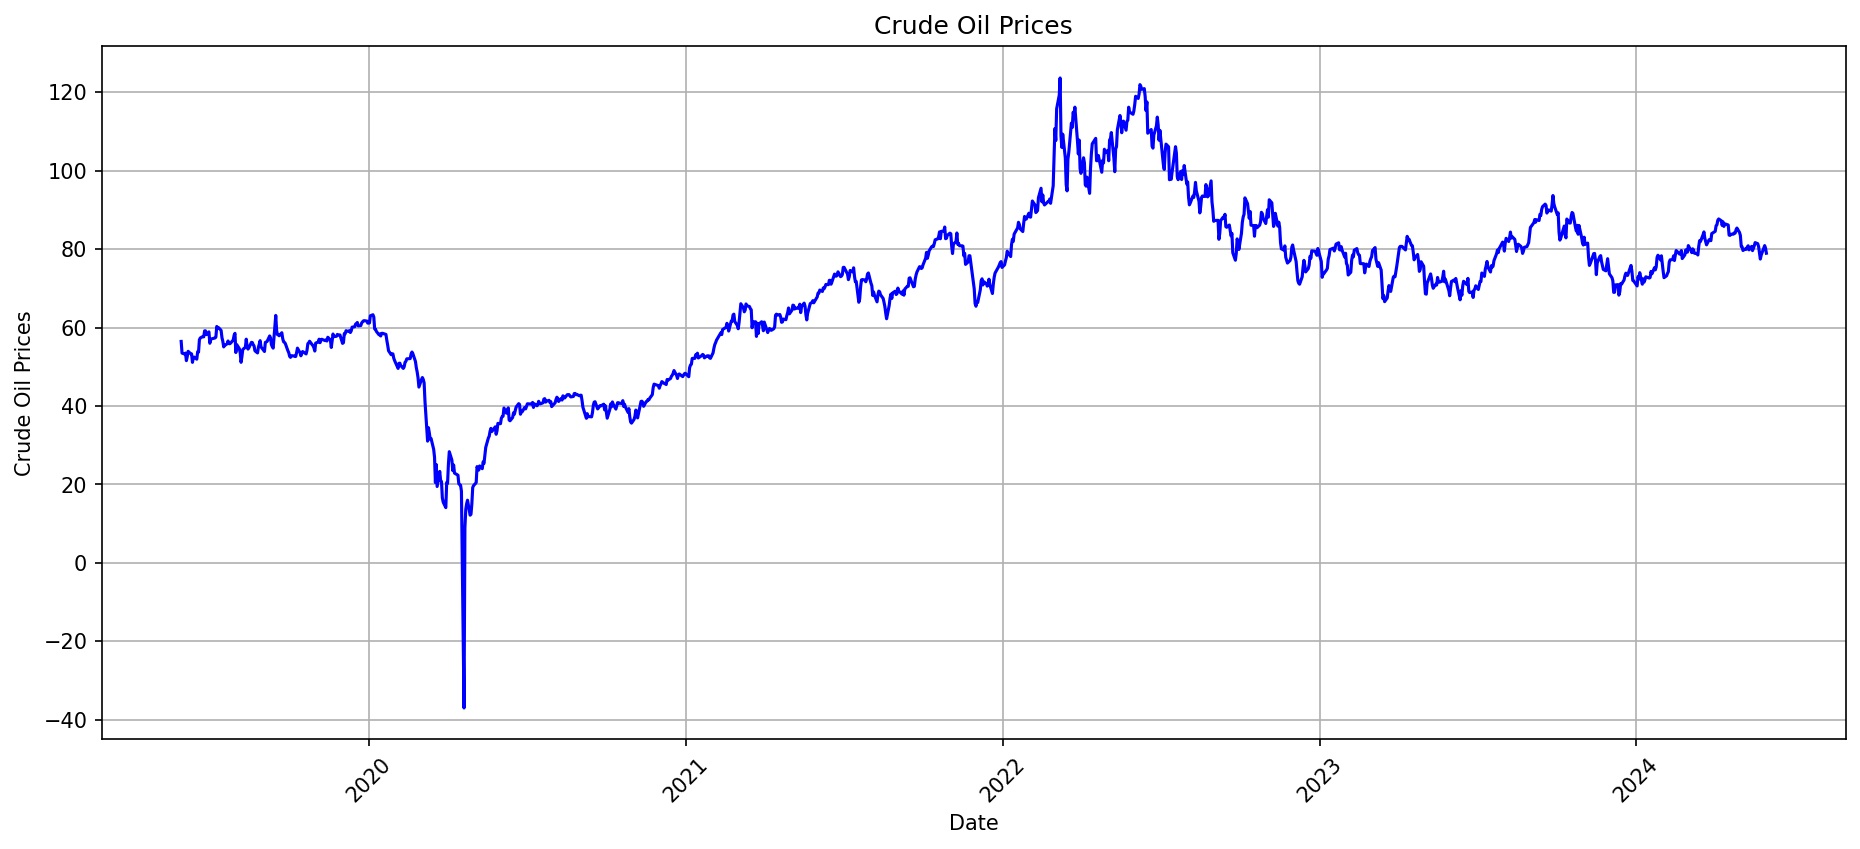

In [ ]:
plt.figure(figsize=(15, 6),dpi=150)
plt.plot(df['DATE'], df['DCOILWTICO'],  linestyle='-',color='blue')
plt.xlabel('Date')
plt.ylabel('Crude Oil Prices')
plt.title('Crude Oil Prices')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        1254 non-null   datetime64[ns]
 1   DCOILWTICO  1254 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.7 KB


In [ ]:
df.tail()

,DATE,DCOILWTICO
1249,2024-05-23,77.47
1250,2024-05-24,78.48
1251,2024-05-28,80.90
1252,2024-05-29,80.24
1253,2024-05-30,78.96


<Figure size 1800x3000 with 0 Axes>

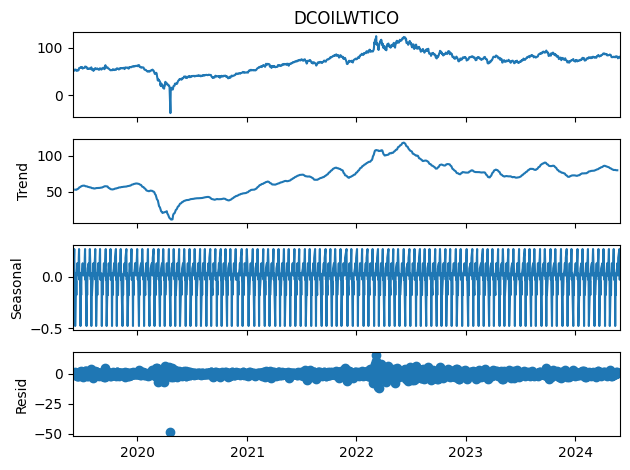

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.set_index('DATE', inplace=True)

# Decompose the time series
result = seasonal_decompose(df['DCOILWTICO'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 20),dpi=150)
result.plot()
plt.show()

# Accessing the components
trend = result.trend
seasonal = result.seasonal
resid = result.resid

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-6wwsx4r3
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-6wwsx4r3
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ac6ee36acee1e47446cd66f72f540c87f1f1fbe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.1-py3-none-any.whl size=13927 sha256=3ccc2450f5219fa5f2eb6d2c6fb7242a51b83aa713efed7dec803328e78b4e5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6hlz2src/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [ ]:
import torch
from chronos import ChronosPipeline

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Split the data
train_data = df.iloc[:1100]
test_data = df.iloc[1100:]  # Ensure proper indexing
test_data1 = df.iloc[1100:1165]
# Limit prediction length to 64
max_prediction_length = 64
train_prediction_length = min(len(train_data), max_prediction_length)
test_prediction_length = min(len(test_data), max_prediction_length)

# Train forecast
forecast_train = pipeline.predict(
    context=torch.tensor(train_data["DCOILWTICO"].values),
    prediction_length=train_prediction_length,
    num_samples=20,
    limit_prediction_length=False,
)

# Test forecast
forecast_test = pipeline.predict(
    context=torch.tensor(test_data["DCOILWTICO"].values),
    prediction_length=test_prediction_length,
    num_samples=20,
    limit_prediction_length=False,
)

# Prepare indices for forecasts
train_forecast_index = range(len(train_data), len(train_data) + train_prediction_length)
test_forecast_index = range(len(train_data), len(train_data) + test_prediction_length)

# Calculate quantiles for training forecast
low_train, median_train, high_train = np.quantile(forecast_train[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Calculate quantiles for testing forecast
low_test, median_test, high_test = np.quantile(forecast_test[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Calculate MSE and RMSE for training forecast
actual_train_values = train_data["DCOILWTICO"].values[-train_prediction_length:]  # Get actual values for comparison
predicted_train_values = median_train  # Use the median as the predicted values for training

mse_train = np.mean((actual_train_values - predicted_train_values) ** 2)
rmse_train = np.sqrt(mse_train)

# Calculate MSE and RMSE for testing forecast
actual_test_values = test_data["DCOILWTICO"].values[:test_prediction_length]  # Get actual values for comparison
predicted_test_values = median_test  # Use the median as the predicted values for testing

mse_test = np.mean((actual_test_values - predicted_test_values) ** 2)
rmse_test = np.sqrt(mse_test)

# Print the results
print(f'Mean Squared Error (MSE) for Training Data: {mse_train}')
print(f'Root Mean Squared Error (RMSE) for Training Data: {rmse_train}')
print(f'Mean Squared Error (MSE) for Testing Data: {mse_test}')
print(f'Root Mean Squared Error (RMSE) for Testing Data: {rmse_test}')



Mean Squared Error (MSE) for Training Data: 33.63554909747296
Root Mean Squared Error (RMSE) for Training Data: 5.79961628881368
Mean Squared Error (MSE) for Testing Data: 47.666375379074886
Root Mean Squared Error (RMSE) for Testing Data: 6.904083963790916


(array([17897., 18262., 18628., 18993., 19358., 19723.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

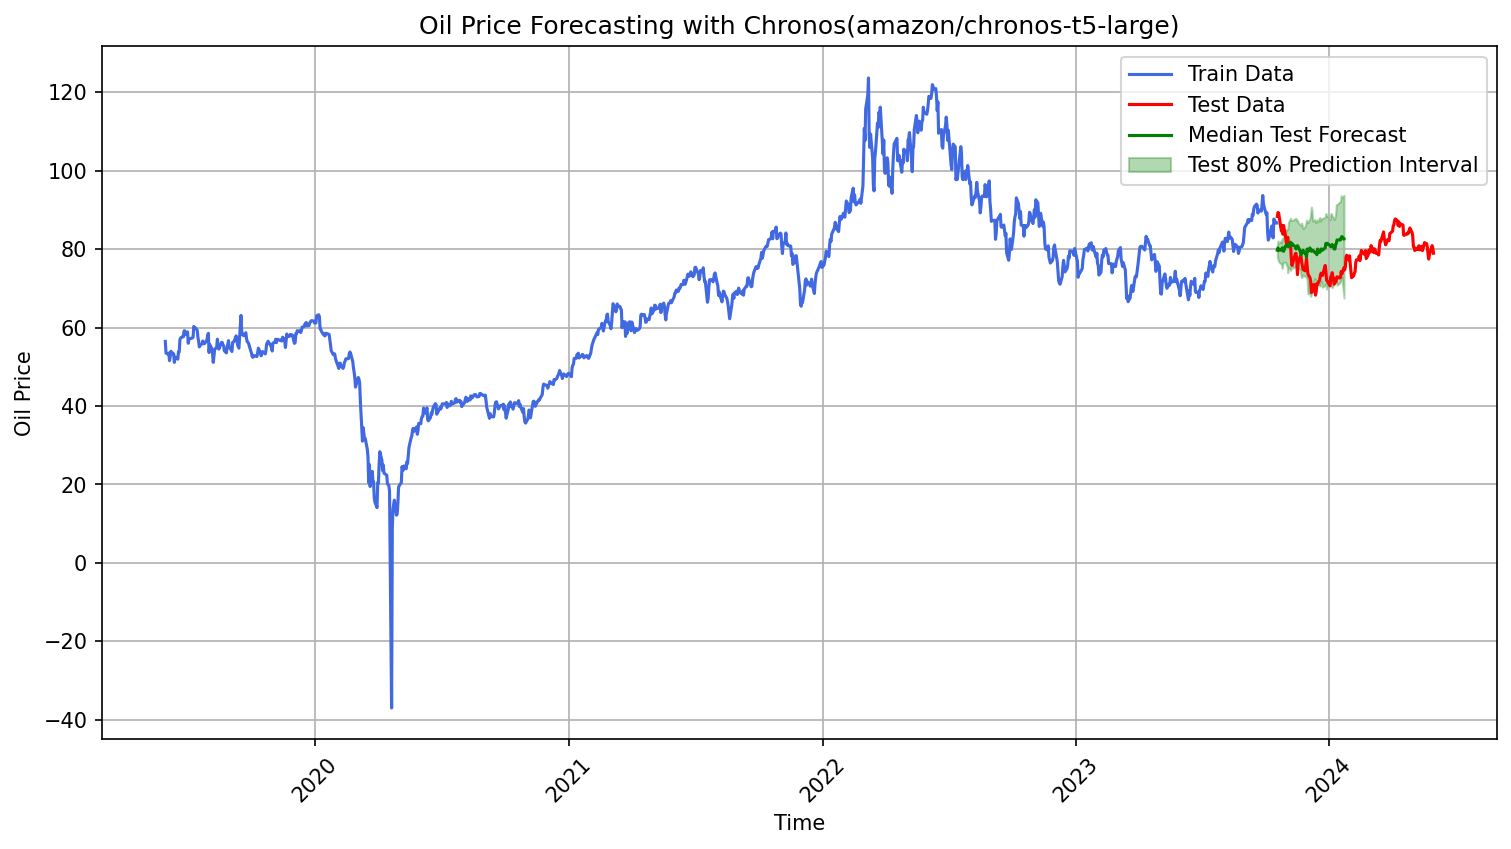

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)

# Plot historical data
plt.plot(train_data["DATE"], train_data["DCOILWTICO"], color="royalblue", label="Train Data")
plt.plot(test_data["DATE"], test_data["DCOILWTICO"], color="red", label="Test Data")

# Prepare the indices for the forecast
test_forecast_index = test_data["DATE"].iloc[:test_prediction_length]  # Get the corresponding dates for the predictions

# Plot testing forecast
plt.plot(test_forecast_index, median_test, color="green", label="Median Test Forecast")
plt.fill_between(test_forecast_index, low_test, high_test, color="green", alpha=0.3, label="Test 80% Prediction Interval")

# Final touches
plt.legend()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Oil Price")
plt.title("Oil Price Forecasting with Chronos(amazon/chronos-t5-large)")
plt.xticks(rotation=45)